In [1]:
import requests

url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
response = requests.get(url)

with open('../data/lin_regr_file.csv', 'wb') as f:
    f.write(response.content)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import plotly.express as px


In [3]:
df = pd.read_csv('../data/lin_regr_file.csv')
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
642,61,male,33.915,0,no,northeast,13143.86485
240,23,female,36.670,2,yes,northeast,38511.62830
1169,37,female,34.105,1,no,northwest,6112.35295
579,25,female,23.465,0,no,northeast,3206.49135
526,19,female,30.590,2,no,northwest,24059.68019


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:

df['age'] = df['age'].astype('int8')

df['smoker'] = df['smoker'].astype('category')

df['children'] = df['children'].astype('Int8')

In [6]:
df['smoker_old'] = df['smoker']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         1338 non-null   int8    
 1   sex         1338 non-null   object  
 2   bmi         1338 non-null   float64 
 3   children    1338 non-null   Int8    
 4   smoker      1338 non-null   category
 5   region      1338 non-null   object  
 6   charges     1338 non-null   float64 
 7   smoker_old  1338 non-null   category
dtypes: Int8(1), category(2), float64(2), int8(1), object(2)
memory usage: 48.7+ KB


In [8]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = '#00000000'

In [9]:
fig = px.histogram(df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

In [10]:
fig2 = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    title='Distibution of BMI',
                    color_discrete_sequence=['red']
                    )
fig2.update_layout(bargap=0.1)
fig2.show()

In [11]:
fig3 = px.histogram(df,
                    x='charges',
                    color='smoker',
                    marginal='box',
                    color_discrete_sequence=['red', 'green'],
                    title='Distribution of Charges')
fig3.update_layout(bargap=0.1)
fig3.show()

In [12]:
fig4 = px.histogram(df,
                     x='smoker',
                     color='sex',
                     color_discrete_sequence=['red', 'green'],
                     title='Distribution of Smokers')
fig4.update_layout(bargap=0.1)
fig4.show()

In [13]:
fig = px.scatter(df,
                 x='age',
                 y='charges',
                 color='smoker',
                 title='Age vs Charges')
fig.show()

In [14]:
fig = px.scatter(df,
                 x='bmi',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='BMI vs Charges',
                 )
fig.show()

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_1241/2717260249.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




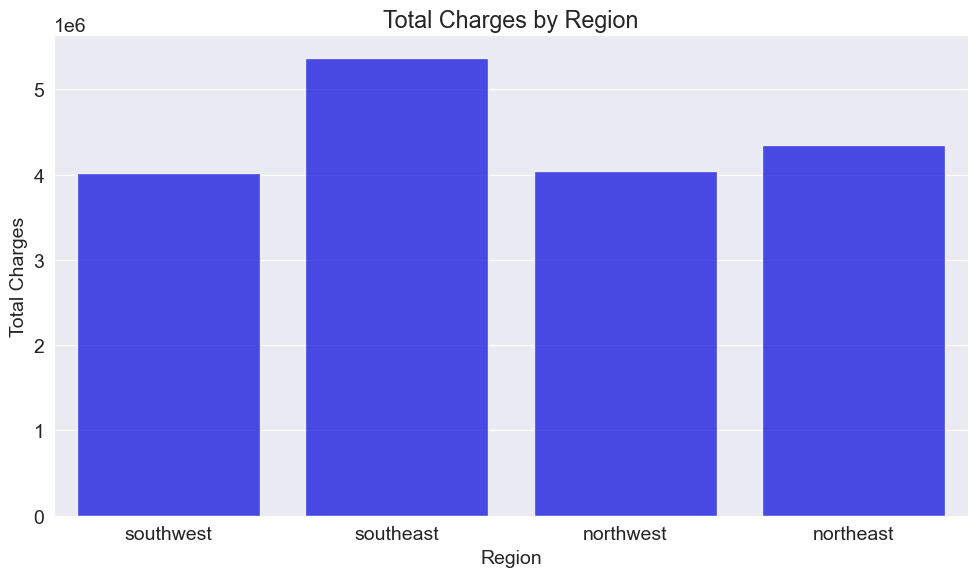

In [15]:
fig = sns.barplot(x='region', y='charges', data=df, estimator=sum, ci=None, color='blue', alpha=0.8)
plt.title('Total Charges by Region')
plt.ylabel('Total Charges')
plt.xlabel('Region')
plt.tight_layout()
plt.show()

In [16]:
fig = px.violin(df,
                y='charges', 
                x='children')
fig.show()

In [17]:
df.charges.corr(df.age)


0.2990081933306478

In [18]:
df.children.corr(df.age)

0.042468998558849495

In [19]:
df['smoker'] = df.smoker.cat.codes

In [20]:
df.bmi.corr(df.charges)

0.1983409688336289

In [21]:
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['region']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["region"]))

df_encoded = pd.concat([df['region'], encoded_df], axis=1)
df_encoded

,region,region_northeast,region_northwest,region_southeast,region_southwest
0,southwest,0.0,0.0,0.0,1.0
1,southeast,0.0,0.0,1.0,0.0
2,southeast,0.0,0.0,1.0,0.0
3,northwest,0.0,1.0,0.0,0.0
4,northwest,0.0,1.0,0.0,0.0
...,...,...,...,...,...
1333,northwest,0.0,1.0,0.0,0.0
1334,northeast,1.0,0.0,0.0,0.0
1335,southeast,0.0,0.0,1.0,0.0
1336,southwest,0.0,0.0,0.0,1.0


In [22]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'smoker_old'],
      dtype='object')

In [23]:
# Show correlation matrix for selected columns
corr_matrix = df[['bmi', 'age', 'smoker', 'children', 'charges']].corr()
corr_matrix

,bmi,age,smoker,children,charges
bmi,1.000000,0.109272,0.003750,0.012759,0.198341
age,0.109272,1.000000,-0.025019,0.042469,0.299008
smoker,0.003750,-0.025019,1.000000,0.007673,0.787251
children,0.012759,0.042469,0.007673,1.000000,0.067998
charges,0.198341,0.299008,0.787251,0.067998,1.000000


<Axes: >

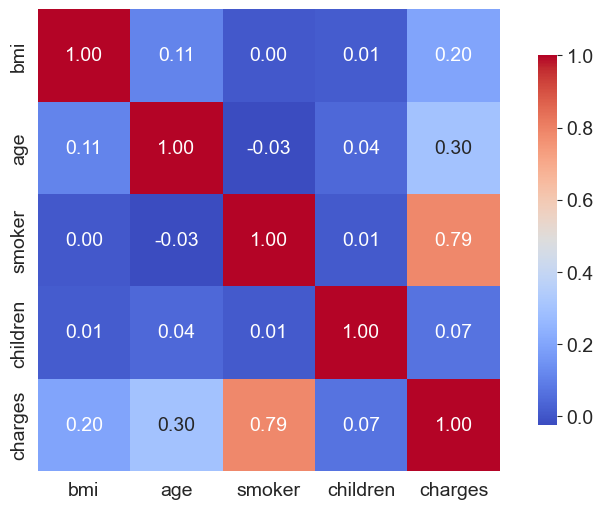

In [24]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})

In [25]:
model1 = LinearRegression()
model2 = LinearRegression()

X1 = df[['smoker', 'age', 'bmi']]
X2 = df[['smoker']]
y = df['charges']

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, random_state=42, test_size=0.2)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=42, test_size=0.2)

In [26]:
model1.fit(X1_train, y_train)
model2.fit(X2_train, y_train)

LinearRegression()

In [27]:
predicted1 = model1.predict(X1_test)
predicted2 = model2.predict(X2_test)
mae1 = mean_absolute_error(y_test, predicted1)
mae2 = mean_absolute_error(y_test, predicted2)
mse1 = mean_squared_error(y_test,predicted1)
mse2 = mean_squared_error(y_test,predicted2)
rmse1 = mse1 ** 0.5
rmse2 = mse2 ** 0.5
r2_1 = r2_score(y_test, predicted1)
r2_2 = r2_score(y_test, predicted2)

In [28]:
print("MAE1:", mae1)
print("MAE2:", mae2)

print("MSE1:", mse1)
print("MSE1:", mse1)

print("RMSE1:", rmse1)
print("RMSE2:", rmse2)

print("R²1:", r2_1)
print("R²2:", r2_2)

MAE1: 4260.560091099382
MAE2: 5625.810656140086
MSE1: 34512843.88022787
MSE1: 34512843.88022787
RMSE1: 5874.763304187486
RMSE2: 7262.641718240421
R²1: 0.7776932310583377
R²2: 0.6602486589056533


In [29]:
#Define feature groups 
num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'region', 'smoker_old']

#preprocessing 
num_trasformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

#Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trasformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)
#addding polynomial 
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

#Final pipeline 

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('regressor', LinearRegression())
]
)

In [30]:
X = df[['age', 'bmi', 'children', 'sex', 'region', 'smoker_old']]
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [31]:
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [32]:
mse = mean_squared_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
rmse = mse ** 0.5
r2 = r2_score(y_test, predicted)

print(f'MSE: {mse}, \nMAE: {mae}, \nRMSE: {rmse}, \nR2: {r2}')

MSE: 21836418.742987335, 
MAE: 2856.3871158544775, 
RMSE: 4672.945403381826, 
R2: 0.8593455899242279


In [36]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("Train R²:", r2_score(y_train, train_pred))
print("Test R²:", r2_score(y_test, test_pred))
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test MAE:", mean_absolute_error(y_test, test_pred))

Train R²: 0.8338719905246493
Test R²: 0.8593455899242279
Train MAE: 3047.002798607477
Test MAE: 2856.3871158544775


In [33]:
param_grid = [
    {'regressor': [LinearRegression()]},
    {'regressor': [Ridge(max_iter=10000)], 'regressor__alpha':[0.1, 1.0, 2.0, 10.0 ]},
    {'regressor': [Lasso(max_iter=10000)], 'regressor__alpha':[0.001, 0.01, 0.1, 1.0 ]},
    {"regressor": [ElasticNet(max_iter=10000)], "regressor__alpha": [0.1, 1.0], "regressor__l1_ratio": [0.2, 0.5, 0.8]}
]

search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_absolute_error")
search.fit(X,y)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+09, tolerance: 1.544e+07

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+09, tolerance: 1.612e+07

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.440e+09, tolerance: 1.567e+07

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'region',
                                                                          'smoker_old'])])),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('regressor', LinearReg...())]),
             param_grid=[{'regressor': [LinearRegression()]},
                         {'regressor': [Ridge(max_iter=10000)],
                          'regressor__alpha': [0.1, 1.0, 2.0, 10.0]},
                         {'regressor': [Lasso(max_iter=10000)],
                          'regressor__alpha': [0.001, 0.01, 0.1, 1.0]},
                         {'regressor': [ElasticNet(max_iter=10000)],
                          'regressor__alpha': [0.1, 1.0],
                          'regressor__l1_ratio': [0.2, 0.5, 0.8]}],
             scoring='neg_mean_absolute_error')

In [34]:
print('Best model: ', search.best_estimator_)
print("Best score:", -search.best_score_)

Best model:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'region',
                                                   'smoker_old'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regressor', LinearRegression())])
Best score: 2936.4985122813823


In [35]:
print(model.named_steps['regressor'].coef_)

[-1.02900023e+16  2.62722079e+16 -6.91090889e+17  8.11756749e+16
  9.31186774e+16  2.13068457e+16  7.94983340e+15  7.01614270e+16
  3.10614781e+16 -7.44894732e+16 -7.97759274e+15  2.44085938e+02
 -2.64847656e+02  4.00166691e+16  4.00166691e+16  2.06325083e+16
  2.06325083e+16  2.06325083e+16  2.06325083e+16 -5.03591751e+16
 -5.03591751e+16  1.64780037e+02 -2.19671668e+16 -2.19671668e+16
  3.52857899e+16  3.52857899e+16  3.52857899e+16  3.52857899e+16
 -3.95908310e+16 -3.95908310e+16  2.38087519e+17  2.38087519e+17
  2.37658312e+17  2.37658312e+17  2.37658312e+17  2.37658312e+17
  2.15345058e+17  2.15345058e+17  6.40000000e+01  6.04840552e+16
  2.94178967e+16 -2.39293262e+16  3.94900325e+16 -1.49779442e+16
 -3.90795328e+16  3.59840117e+16  4.91785320e+15 -4.84293696e+16
  1.49899891e+16 -2.42090328e+15 -2.65224919e+16  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.61554085e+14 -4.32718460e+16
  0.00000000e+00  0.00000000e+00  4.35616167e+16  1.15132478e+15
  0.00000000e+00  3.46972